Reading in the data and then filtering out SNPs which do not meet p value significance before joining the data together.

In [52]:
import polars as pl

# exp: Exposure
# out: Outcome
# ea: Exposure allele
# oa: Other allele

exp_header_dict = {
  'rsID':'rsid',
  'CHROM':'chr_exp',
  'ALT':'ea_exp',
  'REF':'oa_exp',
  'POOLED_ALT_AF':'maf_exp',
  'EFFECT_SIZE':'beta_exp',
  'SE':'se_exp',
  'pvalue':'pval_exp'
}

out_header_dict = {
  'markername':'rsid',
  'chr':'chr_out',
  'bp_hg19':'pos_out',
  'effect_allele':'ea_out',
  'noneffect_allele':'oa_out',
  'effect_allele_freq':'maf_out',
  'beta':'beta_out',
  'se_dgc':'se_out',
  'p_dgc':'pval_out'}

pthresh = 5e-8

# Renaming columns and filtering data to only include observations which fulfill significance threshold
dexp = (pl.scan_csv("dataset/ldlc_gwas.txt",separator="\t")
        .rename(exp_header_dict)
        .filter((pl.col('pval_exp') < pthresh)))
dout = (pl.scan_csv("dataset/mi_gwas.tsv",separator="\t")
        .rename(out_header_dict))

combined = (dexp.join(dout, on='rsid')
            # Convert all data to lowercase
            .with_columns(pl.col('ea_exp').str.to_lowercase())
            .with_columns(pl.col('oa_exp').str.to_lowercase())
            .with_columns(pl.col('ea_out').str.to_lowercase())
            .with_columns(pl.col('oa_out').str.to_lowercase())
            .collect())

print(combined.shape)

(75089, 26)


Harmonizing the data.

Gathering all SNPs using fowards strand with matching effect and alternate alleles between exposure and outcome.

In [53]:
forwards_same = combined.filter(((pl.col('ea_exp') == pl.col('ea_out')) & (pl.col('oa_exp') == pl.col('oa_out'))))

Gathering all SNPs using forwards strand with flipped effect and alternate alleles between exposure and outcome. The effect is then multiplied by -1.

In [54]:
forwards_flipped = (
  combined.filter(((pl.col('ea_exp') == pl.col('oa_out')) & (pl.col('oa_exp') == pl.col('ea_out'))))
  # Flip the signs of the outcome effects
  .with_columns(
    pl.col('beta_out').mul(-1)
  )
)

Flipping the outcome alleles of the remaining SNPs since the remaining valid SNPs must use the reverse strand.

In [65]:
# Find cases where alleles don't match
reverse = (combined.filter(~(((pl.col('ea_exp') == pl.col('ea_out')) & (pl.col('oa_exp') == pl.col('oa_out'))) | 
                            (((pl.col('ea_exp') == pl.col('oa_out')) & (pl.col('oa_exp') == pl.col('ea_out'))))))
            # Flipping the alleles
            .with_columns(pl.col('ea_out').str.replace('a', 't'))
            .with_columns(pl.col('ea_out').str.replace('t', 'a'))
            .with_columns(pl.col('ea_out').str.replace('g', 'c'))
            .with_columns(pl.col('ea_out').str.replace('c', 'g'))
            .with_columns(pl.col('oa_out').str.replace('a', 't'))
            .with_columns(pl.col('oa_out').str.replace('t', 'a'))
            .with_columns(pl.col('oa_out').str.replace('g', 'c'))
            .with_columns(pl.col('oa_out').str.replace('c', 'g'))
)

shape: (68, 4)
┌────────┬────────┬────────┬────────┐
│ ea_exp ┆ oa_exp ┆ ea_out ┆ oa_out │
│ ---    ┆ ---    ┆ ---    ┆ ---    │
│ str    ┆ str    ┆ str    ┆ str    │
╞════════╪════════╪════════╪════════╡
│ a      ┆ t      ┆ g      ┆ t      │
│ c      ┆ g      ┆ g      ┆ a      │
│ a      ┆ g      ┆ g      ┆ t      │
│ t      ┆ a      ┆ c      ┆ a      │
│ …      ┆ …      ┆ …      ┆ …      │
│ c      ┆ ct     ┆ d      ┆ i      │
│ a      ┆ at     ┆ d      ┆ i      │
│ a      ┆ ag     ┆ d      ┆ i      │
│ a      ┆ ac     ┆ d      ┆ i      │
└────────┴────────┴────────┴────────┘


Gathering SNPs from reverse strand which use the same alleles for exposure and outcome.

In [56]:
reverse_same = (
  reverse.filter(((pl.col('ea_exp') == pl.col('ea_out')) & (pl.col('oa_exp') == pl.col('oa_out'))))
)

Gathering SNPs from reverse strand which flipped the effect and alternate alleles. We then multiply the effect by -1.

In [57]:
reverse_flipped = (
  # Find all reversed cases
  reverse.filter(((pl.col('ea_exp') == pl.col('oa_out')) & (pl.col('oa_exp') == pl.col('ea_out'))))
  # Flip the signs of the outcome effects
  .with_columns(
    pl.col('beta_out').mul(-1)
  )
)

Combining all the different cases into one dataframe.

In [58]:
print(forwards_same.shape)
print(forwards_flipped.shape)
print(reverse_same.shape)
print(reverse_flipped.shape)

# Combining all SNPs
total = pl.concat([forwards_same, forwards_flipped, reverse_same, reverse_flipped])

(8679, 26)
(66342, 26)
(1, 26)
(6, 26)


Discarding all palindromic SNPs since we are unable to determine whether the effect and outcome alleles are matching.

In [59]:
total = total.filter(
  ~(((pl.col('ea_exp') == 'a') & (pl.col('oa_exp') == 't')) |
  ((pl.col('ea_exp') == 't') & (pl.col('oa_exp') == 'a')) |
  ((pl.col('ea_exp') == 'g') & (pl.col('oa_exp') == 'c')) |
  ((pl.col('ea_exp') == 'c') & (pl.col('oa_exp') == 'g')))
)

print(total.shape)

(63712, 26)


Pruning the data based on Linkage Disequilibirum (LD).

In [60]:
import ieugwaspy as igd

rsids = total['rsid']
pvals = total['pval_exp']

pruned = igd.api_query(path='/ld/clump', query={'rsid':rsids, 'pval':pvals}, method='POST')

In [63]:
# total.write_csv('dataset/output.txt', separator='\t')
print(len(pruned))
pruned_rsids = pl.DataFrame({'rsid':pruned})
processed_data = (total.join(pruned_rsids, on='rsid'))

444


Calculate the causal effect using the following:

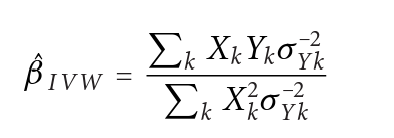

In [62]:
effect = (processed_data['beta_exp'] * processed_data['beta_out'] * processed_data['se_out'] ** -2).sum() / (processed_data['beta_exp'] ** 2 * processed_data['se_out'] ** -2).sum()
print(f'Effect: {effect}')

se = ((processed_data['beta_exp'] ** 2 * processed_data['se_out'] ** -2).sum()) ** -0.5
print(f'se: {se}')

Effect: 0.5666555763511523
se: 0.024475735763108256
